# Baby Cry Classification using Machine Learning Algorithms

**Author**: Jing Chen and Shruti Biradar

## Project Overview - purpose and our solution

**Project Goal**: In the first phase of our research, we aim to classify baby cry based on demographic features of babies and the acoustic cry signals using machine learning techniques and then compare the performance of the different machine learning methods based on the F1 Score metric.

**Inputs**:
*   Audio files in .wav format including file name
*   Acoustic features extracted from audio waves of baby cries, such as Mel-frequency cepstral coefficients and chroma features
*   Demographic features of babies such as age and gender









**Outputs**: Labels of cry reasons:
*   belly pain
*   burping
*   discomfort
*   hunger
*   tiredness












### Structure of Code

        I. Install and Import Packages

        II. Load Dataset- audio files

        III. Exploratory Data Analysis

        IV. Pre-processing and Feature Extraction

        V. Build Classifier

        VI. Run all models and Report Performance

## I. Install and Import packages

In [ ]:
# load required packages
!pip install pydub

import wave
import math
import os
import matplotlib.pyplot as plt
import librosa
import librosa.display
import wave
import pandas as pd
import numpy as np
import pydub
from scipy.io.wavfile import read
from pydub import AudioSegment
from pydub.utils import make_chunks
from os import walk
from os import listdir
from os.path import isfile, join
import random
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from statistics import mean
from matplotlib import pyplot
from sklearn.model_selection import train_test_split,cross_validate,RepeatedStratifiedKFold
from sklearn.metrics import precision_score, recall_score, accuracy_score,precision_recall_fscore_support
from sklearn.metrics import ConfusionMatrixDisplay, multilabel_confusion_matrix
from sklearn.preprocessing import MinMaxScaler,StandardScaler,normalize,LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold,GridSearchCV
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from numpy.linalg import eigh
from sklearn.svm import SVC
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics
from keras.callbacks import ModelCheckpoint
from datetime import datetime
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from datetime import datetime


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## II. Load Dataset- audio files

We use Donate-A-Cry corpus dataset, which consists of 457 unique child cry audio files along with tags for babies’ demographic information (age and gender) and cry reasons (such as hungry, belly pain, discomfort, burping, and tiredness).

In [ ]:
# mount google drive to access files and folders
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
# load the data
audiopath_df = pd.DataFrame(columns=['file','audio_class'])
cwd = os.getcwd()
folder = ['belly_pain', 'burping','discomfort','hungry','tired']
for t in folder:
  folder_path = cwd+'/gdrive/MyDrive/DS5500/audio/'+t
  audiofile_path = [folder_path+'/'+file for file in os.listdir(folder_path) if file.endswith('.wav')]
  file_df=pd.DataFrame({'file':audiofile_path,
                  'audio_class':t})
  audiopath_df = pd.concat([audiopath_df, file_df],ignore_index=True)

In [ ]:
# a snippet of the dataframe
audiopath_df.head(6)

,file,audio_class
0,/content/gdrive/MyDrive/DS5500/audio/belly_pai...,belly_pain
1,/content/gdrive/MyDrive/DS5500/audio/belly_pai...,belly_pain
2,/content/gdrive/MyDrive/DS5500/audio/belly_pai...,belly_pain
3,/content/gdrive/MyDrive/DS5500/audio/belly_pai...,belly_pain
4,/content/gdrive/MyDrive/DS5500/audio/belly_pai...,belly_pain
5,/content/gdrive/MyDrive/DS5500/audio/belly_pai...,belly_pain


## III. Exploratory Data Analysis

In [ ]:
# extract length of file, age and gender of babies from the files and append to the dataframe

def calculate_audio_length(file_path):
    # load audio file using file path and calculate the length of audio in minutes
    y,sr = librosa.load(file_path)
    length = len(y)/sr
    return length

def extract_gender(file_path):
    # extract information on gender from file name
    g = file_path.split("-")[-3]
    if g == "m":
        return "Male"
    else: return "Female"

def extract_age(file_path):
    # extract information on age in month from file name
    a = int(file_path.split("-")[-2])
    return a

In [ ]:
audiopath_df["length"] = audiopath_df["file"].map(lambda x:calculate_audio_length(x))
audiopath_df["gender"] = audiopath_df["file"].map(lambda x:extract_gender(x))
audiopath_df["age_in_months"] = audiopath_df["file"].map(lambda x:extract_age(x))

## IV. Feature Extraction and Dimentionality Reduction

**(1)** Framing:  For an audio file, the waveform is cut into segments with a duration of 1-second

**(2)** Feature Extraction

| Acoustic Feature | Definition | Number of Features Extracted per Frame |
| :-: |:-- | :-: |
| Mel-frequency cepstral coefficients (MFCC)| A set of features derived from log short-term power spectrum of a sound signal  on a nonlinear mel scale of frequency| 39 |
| Spectral Centroid| A number that represents the amplitude at the center of the spectrum of the signal distribution over a window calculated from the Fourier transform frequency.  $$
   Spectral\space Centroid = \frac{\sum\limits_{n=0}^{N-1} f(n)x(n)}{\sum\limits_{n=0}^{N-1} x(n)}
$$ <br> where x(n) is the weighted frequency value of nth bin, and f(n) is the center frequency of nth bin.| 1 |
| Spectral Flatness| A measure that quantifies how much a sound resembles a pure tone rather than noise <br> <br> $${{Spectral\space Flatness}}={\frac  {\exp \left({\frac  {1}{N}}\sum _{{n=0}}^{{N-1}}\ln x(n)\right)}{{\frac  {1}{N}}\sum _{{n=0}}^{{N-1}}x(n)}}$$ <br> where x(n) represents the magnitude of nth bin.| 1 |
| Spectral Contrast| The decibel difference between peaks and valleys in the spectrum| 7  |
| Spectral Rolloff| The frequency below which 85% of the magnitude distribution is concentrated | 1  |
| Chroma Features| A set of features represent the tonal content of a musical audio signal in a condensed form. | 12 |

**(3)** Flattening Features: Each 2-D acoustic feature is converted into 1-d vector before passing as input in the next process by flattening.

**(4)** Dimentionality Reduction and Standardization: We are using use standardization as our scaling method to have data centered around the mean with unit std. deviation in each column and we also do PCA for reducing some 1000+ features to key features that captures most of the information about the data.


In [ ]:
# feature extraction

def processing_audio(audio_df = audiopath_df.head(), n_second = 1):
    i = 0
    cry_reason = []
    mfccs = []
    audio_index = []
    for f in audio_df["file"]:
        y, s = librosa.load(f)
        while len(y)>= s*n_second:
            cry_reason.append(audio_df["audio_class"][i])
            # Start from dividing the sound signal into the form of frames with a duration of 1-seconds
            f1 = y[:s*n_second]
            y = y[s*n_second:]
            # Extract Mel-frequency cepstral coefficients (MFCCs) to represent the short-term power spectrum of sound.
            mfcc = librosa.feature.mfcc(y=f1, sr=s, n_mfcc=39)
            mfccs.append(mfcc)

            audio_index.append(i)
        i += 1
    output_df = pd.DataFrame({"audio_index": audio_index,
                              "cry_reason" : cry_reason,
                              "mfcc" : mfccs
                              })
    return output_df

In [ ]:
def convert_matrix_vector_to_df(matrix_vector):
    # convert a vector of matrix to a vector of arrays by flattening all nested arrays
    flatten_df = matrix_vector.flatten()
    return flatten_df

In [ ]:
def convert_matrix_to_columns(data, column_name):
    # if the first cell of the column is a matrix then convert this column into multiple columns by flattening the matrix
    df = data[column_name].map(lambda x:convert_matrix_vector_to_df(x))
    temp_df = pd.DataFrame(df.tolist(),index = df.index)
    temp_df.columns = [column_name + f'{c}' for c in temp_df.columns]
    data = pd.concat([data,temp_df],axis =1)
    data = data.drop([column_name], axis=1)
    return data

In [ ]:
def feature_extraction(file_path_df):
    data_df = processing_audio(audio_df = audiopath_df, n_second = 1)

    return data_df

#### Convolution Neural Network (CNN)

In [ ]:
# model architecture

def cnn_structure(x_train,x_test,num_labels=5):
  #parametrs for input into the model
  num_rows = 39 #corresponds to height of an image
  num_columns = 44 #corresponds to width of an image
  num_channels = 1 #channels in an image, 1 suggests its a grayscale image

  #reshape our input data to match the

  x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
  x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

  # Construct model
  model = Sequential()

  # Add convolution layers
  #model.add(Conv2D(32,(3,3), input_shape=(num_rows, num_columns, num_channels), activation='relu', kernel_regularizer= regularizers.l2(0.01)))
  model.add(Conv2D(32,(3,3), input_shape=(num_rows, num_columns, num_channels), activation='relu'))
  model.add(MaxPooling2D(2,2))
  model.add(Dropout(0.4))

  #model.add(Conv2D(64,(3,3), activation='relu',kernel_regularizer= regularizers.l2(0.01)))
  model.add(Conv2D(64,(3,3), activation='relu'))
  model.add(MaxPooling2D(2,2))
  model.add(Dropout(0.4))

  #model.add(Conv2D(128,(3,3), activation='relu',kernel_regularizer= regularizers.l2(0.01)))
  model.add(Conv2D(128,(3,3), activation='relu'))
  model.add(MaxPooling2D(2,2))
  model.add(Dropout(0.4))

  # output feature map to flattened vector
  model.add(Flatten())

  # Add fully connected layers
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(5, activation='softmax'))

  return model

In [ ]:
#Train the model
def cnn_model(x_train,x_test,y_train, y_test,x_val, y_val):

  #convert the mfcc and label columns to arrays
  X_train = np.array(x_train.tolist())
  y_train = np.array(y_train.tolist())
  X_test = np.array(x_test.tolist())
  y_test = np.array(y_test.tolist())
  X_val = np.array(x_val.tolist())
  y_val = np.array(y_val.tolist())

  # label encoding
  le = LabelEncoder()
  y_train = to_categorical(le.fit_transform(y_train))
  y_test = to_categorical(le.transform(y_test))
  y_val = to_categorical(le.transform(y_val))

  #build model architecture
  model = cnn_structure(X_train,X_test,5)

  # Compile the model
  model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['categorical_accuracy'])

  num_epochs = 100
  num_batch_size = 128

  # save the best training weights
  model_callback_checkpoint = ModelCheckpoint(filepath='cnn_model/bestmodel.h5',save_best_only=True, monitor='val_loss')
  history = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_val, y_val), callbacks=[model_callback_checkpoint])

  # load the saved model
  new_model = load_model('cnn_model/bestmodel.h5')

  # get model predictions on test data
  predictions = new_model.predict(X_test)

  # since the have our predictions in binary matrix we get the index of the highest prob value
  y_pred = np.argmax(predictions, axis = 1)

  # we apply inverse of label encoder to get the corresponding lables of the numeric values
  y_pred_labels = le.inverse_transform(y_pred)

  return history, y_pred_labels

## VII. Report Performance

In [ ]:
# Define function for reporting performance metrics

def report_performance(test_df,y_pred):
    # input: test data that contains both real label of cry reason and all features
    # output: a dictionary with metric names as keys.

    # calculate the number of audios by cry reason
    test_count = test_df.groupby(['cry_reason']).size()
    reason_dict = test_count.to_dict()

    # build a function that only keeps the most frequent cry reason from an array
    def parse_pred(entry):
        if isinstance(entry, str):
            return entry
        return max(entry, key=lambda x: reason_dict[x])
    pred_dict = {'audio_index': test_df['audio_index'], 'y_test': test_df['cry_reason'], 'y_pred': y_pred}
    temp_df = pd.DataFrame(pred_dict)

    # predict the entire audio's cry reason based on the majority group of predicted labels of its cuts
    temp_result = temp_df.groupby(['audio_index'])[['y_test','y_pred']].agg(pd.Series.mode)
    temp_result['y_pred'] = temp_result['y_pred'].map(parse_pred)

    # calculate precision, recall, and f1 based on the cry reason of orginal audio and predictions
    precision_1, recall_1,f1_1, null_value_1 = precision_recall_fscore_support(temp_result['y_test'],
                                                                               temp_result['y_pred'],
                                                                               average='macro',
                                                                               zero_division=0)

    precision_2, recall_2,f1_2, null_value_2 = precision_recall_fscore_support(temp_result['y_test'],
                                                                               temp_result['y_pred'],
                                                                               average='weighted',
                                                                               zero_division=0)
    # calucate accuracy rate

    accuracy = accuracy_score(temp_result['y_test'],temp_result['y_pred'])
    return {
        'precision_macro': precision_1,
        'recall_macro': recall_1,
        'f1_macro': f1_1,
        'precision_weighted': precision_2,
        'recall_weighted': recall_2,
        'f1_weighted': f1_2,
        'accuracy': accuracy
    }

In [ ]:
### Feature Extraction
data_df = feature_extraction(audiopath_df)

In [ ]:
# prep the data for input

y = data_df['cry_reason']
X = data_df.copy()

print(X.shape)
print(y.shape)

(2949, 3)
(2949,)


In [ ]:
# train-test-val split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(1887, 3)
(472, 3)
(590, 3)
(1887,)
(590,)
(472,)


Epoch 1/100
15/15 [==============================] - 6s 381ms/step - loss: 5.4434 - categorical_accuracy: 0.6635 - val_loss: 1.2252 - val_categorical_accuracy: 0.6398
Epoch 2/100
15/15 [==============================] - 3s 227ms/step - loss: 0.9718 - categorical_accuracy: 0.8002 - val_loss: 1.3686 - val_categorical_accuracy: 0.8199
Epoch 3/100
15/15 [==============================] - 3s 231ms/step - loss: 0.7966 - categorical_accuracy: 0.8352 - val_loss: 1.2387 - val_categorical_accuracy: 0.8199
Epoch 4/100
15/15 [==============================] - 4s 305ms/step - loss: 0.7561 - categorical_accuracy: 0.8368 - val_loss: 1.2745 - val_categorical_accuracy: 0.8199
Epoch 5/100
15/15 [==============================] - 4s 230ms/step - loss: 0.7404 - categorical_accuracy: 0.8368 - val_loss: 1.2398 - val_categorical_accuracy: 0.8199
Epoch 6/100
15/15 [==============================] - 3s 224ms/step - loss: 0.7468 - categorical_accuracy: 0.8389 - val_loss: 1.2341 - val_categorical_accuracy: 0.819

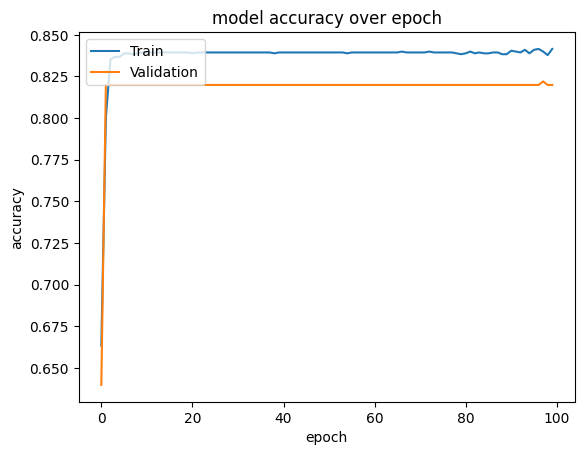

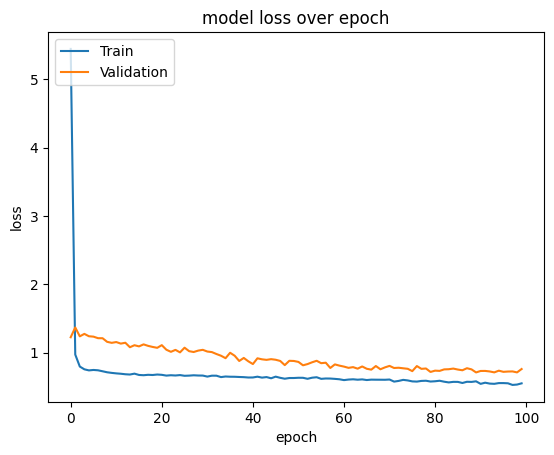

,precision_macro,recall_macro,f1_macro,precision_weighted,recall_weighted,f1_weighted,accuracy
0,0.166957,0.2,0.181991,0.696862,0.834783,0.759613,0.834783


In [ ]:
# Model predictions
history, y_pred = cnn_model(X_train['mfcc'], X_test['mfcc'], y_train, y_test, X_val['mfcc'], y_val)

# summarize training and val accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy over epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize training and val loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss over epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# calculate performance metrics
metrics_dict = report_performance(X_test,y_pred)
metrics_df = pd.Series(metrics_dict).to_frame().T

metrics_df

In [ ]:
'''
for model in models:
  print('model', model)
  for i in range(4):
        print('fold', i)
        train_df = data_df[data_df['k_fold_index']!=i]
        test_df = data_df[data_df['k_fold_index']==i]
        X_train = train_df['mfcc']
        y_train = train_df['cry_reason']
        X_test = test_df['mfcc']
        y_test = test_df['cry_reason']
        history, y_pred = eval(model)

        # summarize training and val accuracy
        plt.plot(history.history['categorical_accuracy'])
        plt.plot(history.history['val_categorical_accuracy'])
        plt.title('model accuracy over epoch')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()
        # summarize training and val loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss over epoch')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()


        metrics_dict = report_performance(test_df,y_pred)
        if i == 0 and model == models[0]:
            metrics_df = pd.Series(metrics_dict).to_frame().T
            metrics_df['model_name'] = model.split('(')[0]
        else:
            temp_df = pd.Series(metrics_dict).to_frame().T
            temp_df['model_name'] = model.split('(')[0]
            metrics_df = pd.concat([metrics_df, temp_df],axis = 0)
'''

model cnn_model(X_train,X_test,y_train, y_test)
fold 0
Epoch 1/100
18/18 [==============================] - ETA: 0s - loss: 4.9199 - categorical_accuracy: 0.6987

ValueError: ignored

In [ ]:
#metrics_df

,precision_macro,recall_macro,f1_macro,precision_weighted,recall_weighted,f1_weighted,accuracy,model_name
0,0.163158,0.200000,0.179710,0.665512,0.815789,0.733028,0.815789,baseline
0,0.161404,0.200000,0.178641,0.651277,0.807018,0.720831,0.807018,baseline
0,0.173684,0.200000,0.185915,0.754155,0.868421,0.807265,0.868421,baseline
0,0.170175,0.200000,0.183886,0.723992,0.850877,0.782323,0.850877,baseline
0,0.163158,0.200000,0.179710,0.665512,0.815789,0.733028,0.815789,grid_svm
0,0.161404,0.200000,0.178641,0.651277,0.807018,0.720831,0.807018,grid_svm
0,0.173684,0.200000,0.185915,0.754155,0.868421,0.807265,0.868421,grid_svm
0,0.170175,0.200000,0.183886,0.723992,0.850877,0.782323,0.850877,grid_svm
0,0.163158,0.200000,0.179710,0.665512,0.815789,0.733028,0.815789,rf_pca
0,0.161404,0.200000,0.178641,0.651277,0.807018,0.720831,0.807018,rf_pca


In [ ]:
#cross_validation_result = metrics_df.groupby(['model_name']).mean()
#cross_validation_result

,precision_macro,recall_macro,f1_macro,precision_weighted,recall_weighted,f1_weighted,accuracy
model_name,,,,,,,
baseline,0.167105,0.200000,0.182038,0.698734,0.835526,0.760862,0.835526
brf_pca,0.209038,0.268779,0.157879,0.708683,0.302632,0.396108,0.302632
cnn_model,0.293798,0.239297,0.241889,0.747507,0.839912,0.778883,0.839912
grid_svm,0.167105,0.200000,0.182038,0.698734,0.835526,0.760862,0.835526
rf_pca,0.167105,0.200000,0.182038,0.698734,0.835526,0.760862,0.835526
